In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 13.8 MB/s eta 0:00:00


#**Visualize Images from the Dataset**

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


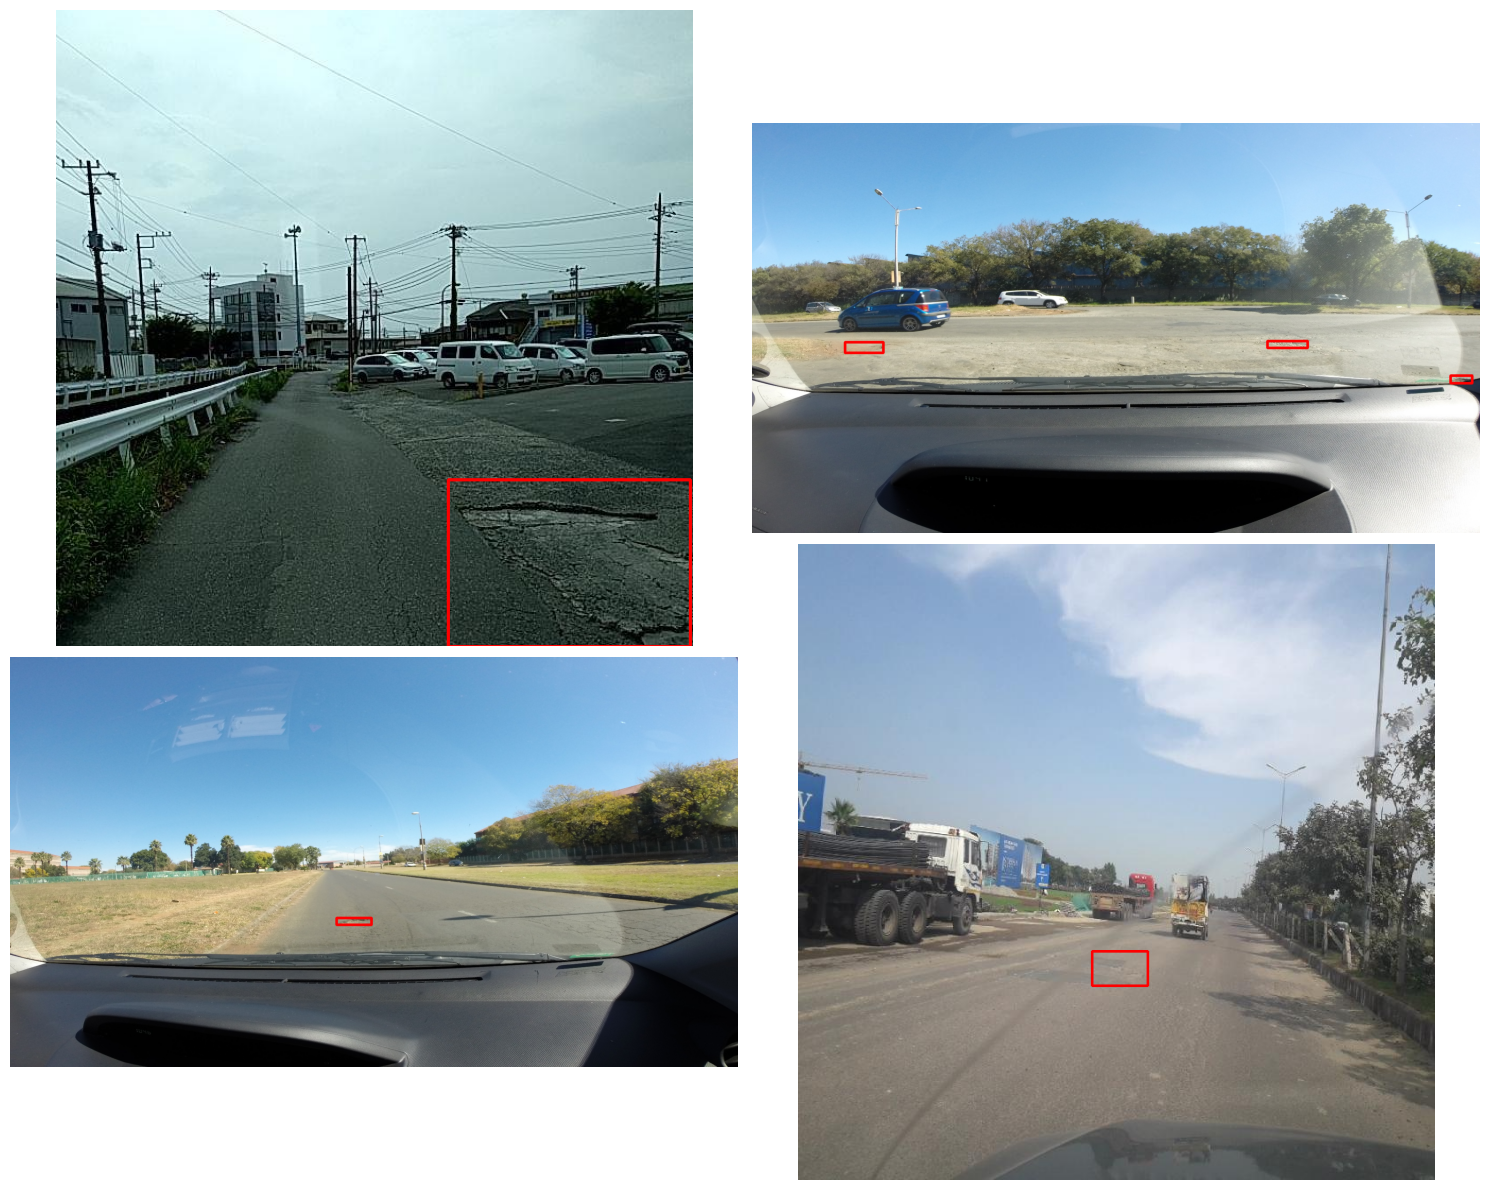

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/drive/MyDrive/pothole_dataset_v8/train/images',
    label_paths='/content/drive/MyDrive/pothole_dataset_v8/train/labels',
    num_samples=4,
)

#**YOLOv8 Nano Training**

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt imgsz=640 data=/content/drive/MyDrive/pothole_dataset_v8/pothole.yaml epochs=5 batch=8 name=yolov8n_custom


100% 6.23M/6.23M [00:00<00:00, 266MB/s]
Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/pothole_dataset_v8/pothole.yaml, epochs=5, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=

#**Evaluation on Validation Images**

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/yolov8n_custom/weights/best.pt name=yolov8n_eval data=/content/drive/MyDrive/pothole_dataset_v8/pothole.yaml

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/labels.cache... 186 images, 0 backgrounds, 0 corrupt: 100% 186/186 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/images/G0011603.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/images/G0011614.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/images/G0011616.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/images/G0011661.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/images/G0011662.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/pothole_dataset_v8/train_to_valid/

#**Inference on Validation Images**

In [ ]:
!yolo task=detect \
mode=predict \
model=/content/runs/detect/yolov8n_custom/weights/best.pt \
source=/content/drive/MyDrive/pothole_dataset_v8/valid/images\
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/271 /content/drive/MyDrive/pothole_dataset_v8/valid/images/G0011195.jpg: 736x1280 (no detections), 58.5ms
image 2/271 /content/drive/MyDrive/pothole_dataset_v8/valid/images/G0011196.jpg: 736x1280 1 pothole, 12.3ms
image 3/271 /content/drive/MyDrive/pothole_dataset_v8/valid/images/G0011242.jpg: 736x1280 (no detections), 12.3ms
image 4/271 /content/drive/MyDrive/pothole_dataset_v8/valid/images/G0011243.jpg: 736x1280 (no detections), 12.3ms
image 5/271 /content/drive/MyDrive/pothole_dataset_v8/valid/images/G0011244.jpg: 736x1280 1 pothole, 12.3ms
image 6/271 /content/drive/MyDrive/pothole_dataset_v8/valid/images/G0011427.jpg: 736x1280 (no detections), 12.3ms
image 7/271 /content/drive/MyDr

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

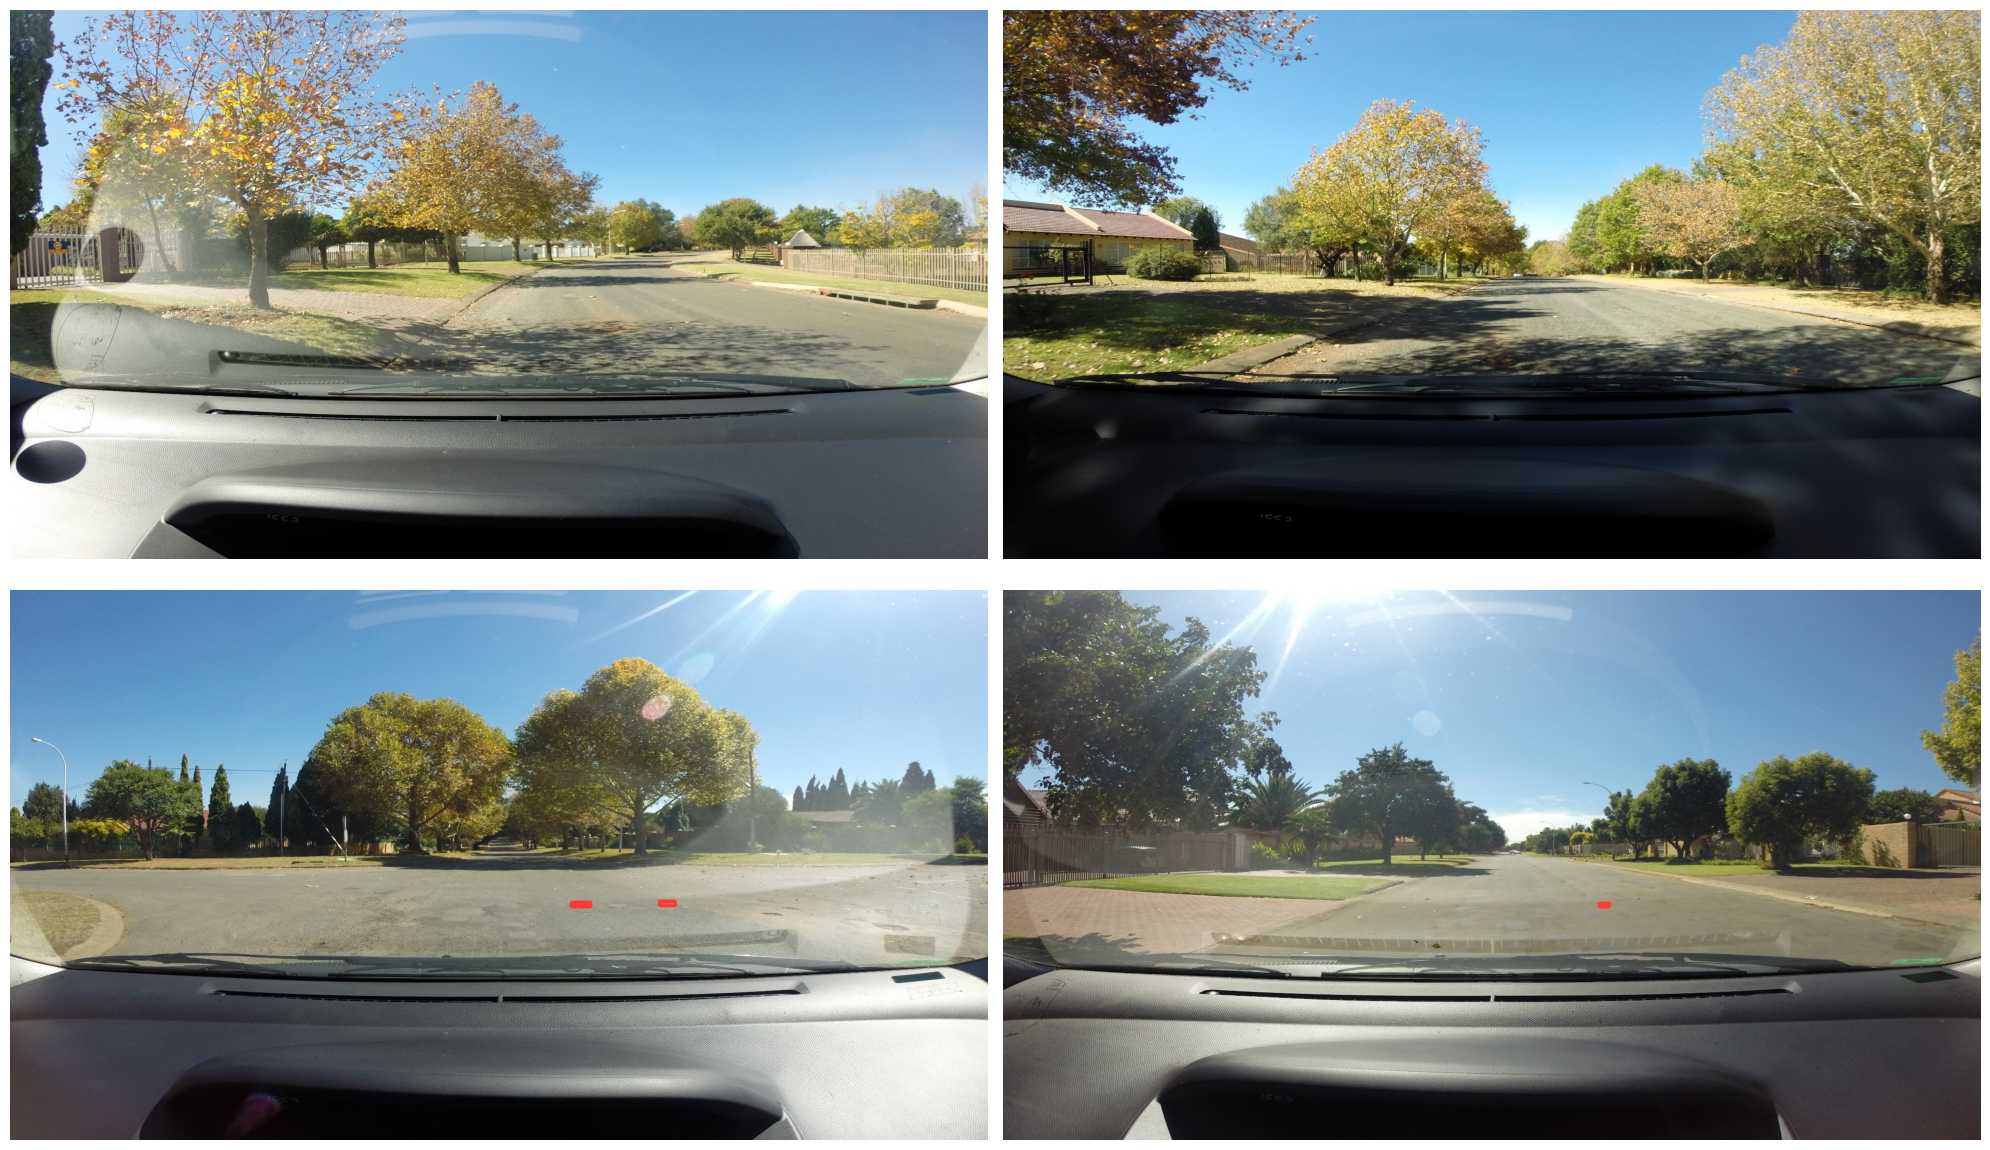

In [ ]:
visualize('/content/runs/detect/yolov8n_v8_50e_infer1280')